<h1> Walmart Sales Project <h1>

The goal of this project is to build a machine learning model able to estimate the weekly sales in the Walmart stores, with the best precision possible on the predictions made.

<h4> Import librairies <h4>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore") # to avoid deprecation warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode"

import datetime

<h4> Upload and take a first look at the dataset <h4>

In [2]:
dataset = pd.read_csv('Walmart_Store_sales.csv')

Preview and basic statistics

In [3]:
print(f"Number of rows : {dataset.shape[0]}")
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
display(dataset.describe(include='all'))
print()

print("Percentage of missing values: ")
display(100 * dataset.isnull().sum() / dataset.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

Each line represents the different stores as well as its sales for the week, there is also the date, the temperature, school holidays or not, the price of fuel, the unemployment rate and finally the Consumer Price Index ('CPI').

Here some observations from this preview:

- We can notice that there is missing values, especially in the target, the Weekly sales. 
- There is also values which seems pretty high in the maximum for some of the features like the Unemployment, we should take care of the outliers.
- Temperature is in degree Fahrenheit
- Holiday Flag only take 0 and 1 as values, which must be meaning holiday (1) or not (0).
- The number of rows (150) is quite small to do a good machine learning model

<h4> Cleaning <h4>

Drop the lines where there is missing values in the weekly sales

In [4]:
# drop the lines in the dataset for which the value in Weekly_Sales is missing
mask = ~dataset.Weekly_Sales.isnull()
dataset = dataset.loc[mask, :]
dataset = dataset.reset_index(drop=True)
print(dataset.shape)


(136, 8)


Drop the lines where there is missing values in the date as we are going to build several other features from this one, this would give us a lot of missing data

In [5]:
mask = ~dataset.Date.isnull()
dataset = dataset.loc[mask, :]
dataset = dataset.reset_index(drop=True)
print(dataset.shape)

(118, 8)


Drop lines containing outliers [Xˉ−3σ, Xˉ+3σ]

In [6]:

liste_col = ['Temperature','Fuel_Price','CPI','Unemployment']
for element in liste_col:
    inf_limit = (dataset[element].mean() - (3 *(dataset[element].std()) ))
    sup_limit = (dataset[element].mean() + (3 *(dataset[element].std())))
    mask = ((dataset[element] > inf_limit) & (dataset[element] < sup_limit))
    dataset = dataset.loc[mask,:]
print('Rows:',dataset.shape [0])

Rows: 80


In [7]:

# create usable features from the Date column
dataset.Date = pd.to_datetime(dataset.Date, format="%d-%m-%Y")
dataset["Year"] = dataset.Date.dt.year
dataset["Month"] = dataset.Date.dt.month
dataset["Day"] = dataset.Date.dt.day
print(dataset.shape)


# drop Date column
dataset.drop(["Date"], axis=1, inplace=True)
print(dataset.shape)
print(100*dataset.isnull().sum()/dataset.shape[0])
dataset.head()

(80, 11)
(80, 10)
Store            0.00
Weekly_Sales     0.00
Holiday_Flag    11.25
Temperature      0.00
Fuel_Price       0.00
CPI              0.00
Unemployment     0.00
Year             0.00
Month            0.00
Day              0.00
dtype: float64


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25
2,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28
4,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3
5,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3


After verification the day of the week is useless to extract, it seems that the day of the week is always friday, it must be the day where the report is done.

In [8]:
fig_vis= make_subplots(rows = 11, cols = 2, subplot_titles = ("Feature distribution", "Target in function of the feature"), row_heights= [700, 700,700,700,700,700,700,700,700,700,700])
n_row = 1
for col in dataset.columns:

    fig = (px.scatter(x = dataset.loc[:,col], 
                        y = (dataset.loc[:,'Weekly_Sales']) ))
    fig_vis.add_trace(fig.data[0], 
                    row = n_row,
                    col = 2,
                     )

    fig_vis.add_trace(go.Histogram(x = dataset[col], nbinsx = dataset[col].nunique(), marker=dict(color='#1f77b4')), 
                row = n_row,
                col = 1,
                 )

    n_row +=1

fig_vis.update_layout(
    height=3500, 
    width=1500,
    yaxis1_title = 'Count',
    yaxis2_title = 'Weekly Sales',
    yaxis3_title = 'Count',
    yaxis4_title = 'Weekly Sales',
    yaxis5_title = 'Count',
    yaxis6_title = 'Weekly Sales',
    yaxis7_title = 'Count',
    yaxis8_title = 'Weekly Sales',
    yaxis9_title = 'Count',
    yaxis10_title = 'Weekly Sales',
    yaxis11_title = 'Count',
    yaxis12_title = 'Weekly Sales',
    yaxis13_title = 'Count',
    yaxis14_title = 'Weekly Sales',
    yaxis15_title = 'Count',
    yaxis16_title = 'Weekly Sales',
    yaxis17_title = 'Count',
    yaxis18_title = 'Weekly Sales',
    yaxis19_title = 'Count',
    yaxis20_title = 'Weekly Sales',
    yaxis21_title = 'Count',
    yaxis22_title = 'Weekly Sales',
    xaxis1_title = 'Store',
    xaxis2_title = 'Store',
    xaxis3_title = 'Weekly_Sales',
    xaxis4_title = 'Weekly_Sales',
    xaxis5_title = 'Holiday_Flag',
    xaxis6_title = 'Holiday_Flag',
    xaxis7_title = 'Temperature',
    xaxis8_title = 'Temperature',
    xaxis9_title = 'Fuel_Price',
    xaxis10_title = 'Fuel_Price',
    xaxis11_title = 'CPI',
    xaxis12_title = 'CPI',
    xaxis13_title = 'Unemployment',
    xaxis14_title = 'Unemployment',
    xaxis15_title = 'Year',
    xaxis16_title = 'Year',
    xaxis17_title = 'Month',
    xaxis18_title = 'Month',
    xaxis19_title = 'Day',
    xaxis20_title = 'Day',
    xaxis21_title = 'DayOfWeek',
    xaxis22_title = 'DayOfWeek',
    
    title={
        'y':0.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    showlegend = False,
    margin=go.layout.Margin(l=150,
                                                r=50,
                                                b=50,
                                                t=80,
                                                pad = 4
                                                ),
) 
fig_vis.update_annotations(yshift=30)

On the sales we can notice:

- A disparity in sales among the stores, for example the one with the higher sales (number 4) has almost 9 times (2.77M) the sales of the store with the lower sales (number 5 with 313k).
- A disparity in sales among the month, the sales seems higher in december
- A disparity in sales among the CPI, with a lower CPI the sales seems higher

We can also notice that:
- We have more data in 2010 than in 2011 and 2022
- Distribution for fuel and CPI is not homogenous, we have for both two distinct groups

<AxesSubplot:>

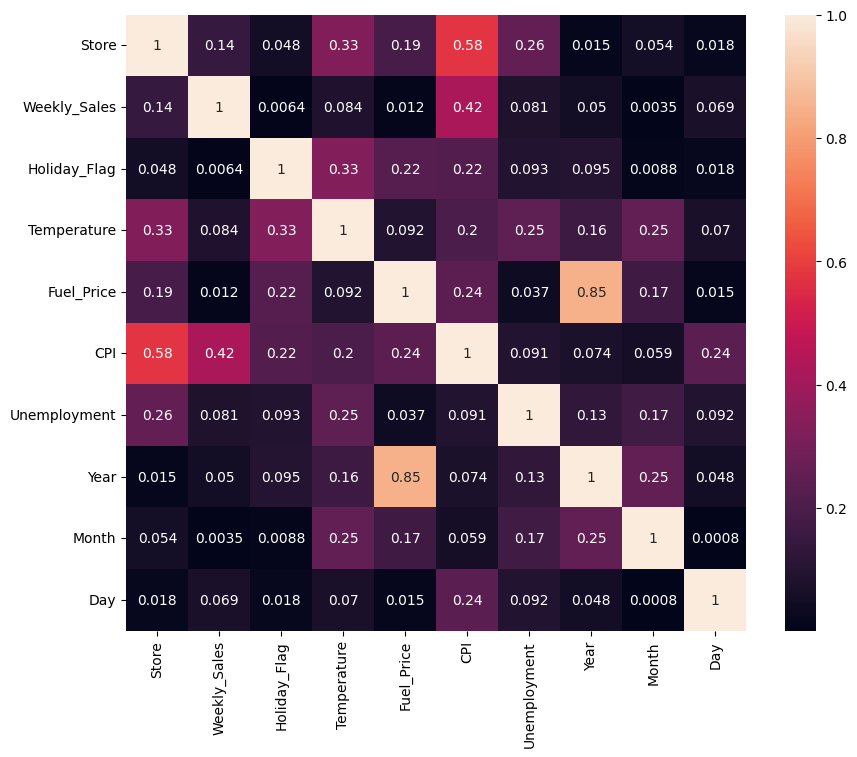

In [9]:
plt.figure(figsize=(10,8))
data_corr=dataset.corr()
sns.heatmap(abs(data_corr),annot=True)

The highest correlation of the weekly sales seems to be first with CPI (0.37), then with Unemployement rate (0.094) and Temperature (0.091).

<h1> Linear regression baseline  <h1>

<h4> Preprocessing <h4>

In [10]:
features_list = ["Store", 'Day', 'Month','Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year']
target_variable = "Weekly_Sales"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]
print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Y : 
0    1572117.54
1    1807545.43
2    1644470.66
4     695396.19
5    2203523.20
Name: Weekly_Sales, dtype: float64

X :
   Store  Day  Month  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0    6.0   18      2           NaN        59.61       3.045  214.777523   
1   13.0   25      3           0.0        42.38       3.435  128.616064   
2    6.0   28      5           0.0        78.89       2.759  212.412888   
4   15.0    3      6           0.0        69.80       4.069  134.855161   
5   20.0    3      2           0.0        39.93       3.617  213.023622   

   Unemployment  Year  
0         6.858  2011  
1         7.470  2011  
2         7.092  2010  
4         7.658  2011  
5         6.961  2012  


Train Test splitting

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)



Preprocessing pipeline

In [12]:


num_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
cat_features = ['Store', 'Holiday_Flag']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) 
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

Preprocessing

In [13]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

<h1> Baseline Model <h1>

Simple linear regression model

In [14]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_train_pred = regressor.predict(X_train) 
print(Y_train_pred)
Y_test_pred = regressor.predict(X_test)
print(Y_test_pred)

[ 661205.52607271 2065782.50300214  488153.07701889 1577782.98377358
 1096343.21723096 2132828.37325848 2520583.95391752 1238761.1488062
 2016148.21001085  453759.85975499  916317.60279494 1757242.51
 1137618.41211196  332402.48555674 2192128.25982502 2150277.74433004
 1916812.74       2000872.30389543  208658.0961066   652255.31534727
 2370294.0932553   505386.22997035 1555976.53012356  466732.74024501
  468512.12038339 1934590.75973129 1892246.80080434 2071824.39802002
  505192.15486756 1406230.57222906 1558926.89520427  593349.17135224
 1551110.04844493  595375.88001683  898300.40736762 1903439.97444696
  801068.07590709 1609614.22100215 2089040.66284608 1364821.87726999
  814227.98581562 1386099.63706629  823256.74015836  481542.2346952
 1322074.44618352 1543965.8788743  1676971.84102216 1098739.14328945
  484567.5990661   907770.57461467 1891528.35593866 1892930.83555304
  977076.36677477  470907.22690789  157721.41392305 1971052.84878578
 1971373.36630262  285271.95005459  882499

In [15]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))
print("Difference Train/Test:", ((r2_score(Y_train, Y_train_pred)-r2_score(Y_test, Y_test_pred)) * 100), '%')

R2 score on training set :  0.9836324565641431
R2 score on test set :  0.9594882534319735
Difference Train/Test: 2.4144203132169584 %


The score is not bad but the model is overfitting, we are gonna try to reduce this overfitting.

<h1> Fight Overfitting <h1>

In [16]:
from sklearn.model_selection import cross_val_score, GridSearchCV

<h4> Regularization with Ridge <h4>

In [17]:
from sklearn.linear_model import Ridge
regressor = Ridge()

params = {
    'alpha': [0,0.001,0.01,0.1,1,10,20,100] 
}
ridge = GridSearchCV(regressor, param_grid = params, cv = 5) 
ridge.fit(X_train, Y_train)

print("Best hyperparameters : ", ridge.best_params_)
print("R2 score on training set : ", ridge.best_estimator_.score(X_train, Y_train))
print("R2 score on test set : ", ridge.best_estimator_.score(X_test, Y_test))
print("Difference Train/Test:", ((ridge.best_estimator_.score(X_train, Y_train)-ridge.score(X_test, Y_test)) * 100), '%')

Best hyperparameters :  {'alpha': 0}
R2 score on training set :  0.9836324565641432
R2 score on test set :  0.9594882534319938
Difference Train/Test: 2.4144203132149378 %


The score is improving, and the overfitting is very slightly better, but we gonna see if we can still improve, with Lasso

<h4> Regularization with Lasso <h4>

In [18]:
from sklearn.linear_model import Lasso

In [19]:
from sklearn.linear_model import Lasso
regressor = Lasso()

params = {
    'alpha': [0.1,1,10,50,340,500], "max_iter": [i for i in range(0,500,10)] 
}
lasso = GridSearchCV(regressor, param_grid = params, cv = 5) 
lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", lasso.best_params_)
print("R2 score on training set : ", lasso.best_estimator_.score(X_train, Y_train))
print("R2 score on test set : ", lasso.best_estimator_.score(X_test, Y_test))
print("Difference Train/Test:", (((lasso.best_estimator_.score(X_train, Y_train))-(lasso.best_estimator_.score(X_test, Y_test))) * 100), '%')

...Done.
Best hyperparameters :  {'alpha': 340, 'max_iter': 410}
R2 score on training set :  0.981220647219033
R2 score on test set :  0.9785479017569212
Difference Train/Test: 0.2672745462111825 %


The R2 score on the test set improved by almost 2 percent, and the overfitting has been reduced to a difference of 0.27% of R2 score between the train and the test set.

We can now look at the features importance, and see what mostly influence the weekly sales.

<h4> Features importance <h4>

In [23]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: 
    if name == 'num': 
        features = features_list 
    else: 
        features = pipeline.named_steps['encoder'].get_feature_names_out() 
    column_names.extend(features)

In [24]:
best_coefs = pd.DataFrame( index = column_names, data = lasso.best_estimator_.coef_.transpose(),columns=['Best_lasso'])
best_coefs

best_feature_importance= abs(best_coefs).sort_values(by = 'Best_lasso')
fig = px.bar(best_feature_importance, orientation = 'h', title = 'Best Features importance')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120}, 
                xaxis1_title  = 'Coefficients values')
fig.show()

We can see that that the feature which influence the most the weekly sales is the store, then as we thought the Consumer Price Index is the second most important.

<H1> Conclusion <H1>

In conclusion the Linear regression model with Lasso regularization gave us the best predictions with the lowest overfitting basing his predictions mainly on the store and Consumer Price Index features.
However, we need to take care with this result as the initial dataset was already small with 150 rows, and after some cleaning we end up with only 80 rows.